In [2]:
import os
from urllib.parse import quote_plus
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from joblib import dump

HOST = os.getenv("DB_HOST")
PORT = os.getenv("DB_PORT")
DB   = os.getenv("DB_NAME")
USER = os.getenv("DB_USER")
PASS = quote_plus(os.getenv("DB_PASSWORD") or "")  # por si hay caracteres especiales

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASS}@{HOST}:{PORT}/{DB}")
Q = """
SELECT ts, src_ip, dst_ip, src_port, dst_port, protocol,
       throughput_bps_t, pps_t, y_bps_next_1s
FROM training_bps_h1s_v3
WHERE y_bps_next_1s IS NOT NULL
ORDER BY ts;
"""
df = pd.read_sql(Q, engine)

# ID de flujo direccional (string-safe incluso si src_ip/dst_ip vienen como inet/IPv4Address)
df["flow_id"] = (df["src_ip"].astype(str)+":"+df["src_port"].astype(str)+">"+
                 df["dst_ip"].astype(str)+":"+df["dst_port"].astype(str)+"/"+
                 df["protocol"].astype(str))

# sanity check rápido
print(df.shape, df.head(3))


(15442, 10)                          ts    src_ip    dst_ip  src_port  dst_port  protocol  \
0 2025-09-05 20:58:12+00:00  10.0.0.1  10.0.0.2      5201     55886         6   
1 2025-09-05 20:58:12+00:00  10.0.0.1  10.0.0.2      5201     55884         6   
2 2025-09-05 20:58:13+00:00  10.0.0.1  10.0.0.2      5201     55886         6   

   throughput_bps_t     pps_t  y_bps_next_1s                         flow_id  
0           9420.70  876302.0         138.82  10.0.0.1:5201>10.0.0.2:55886/6  
1              0.00       3.0           0.00  10.0.0.1:5201>10.0.0.2:55884/6  
2            138.82  100020.0          36.72  10.0.0.1:5201>10.0.0.2:55886/6  


In [3]:
def add_lags_rolls(g):
    g = g.sort_values("ts")
    for k in [1,2,3,5]:
        g[f"thr_lag{k}"] = g["throughput_bps_t"].shift(k)
        g[f"pps_lag{k}"] = g["pps_t"].shift(k)
    g["thr_ma_5"]   = g["throughput_bps_t"].rolling(5, min_periods=1).mean()
    g["thr_std_5"]  = g["throughput_bps_t"].rolling(5, min_periods=2).std()
    g["pps_ma_5"]   = g["pps_t"].rolling(5, min_periods=1).mean()
    g["thr_slope5"] = g["throughput_bps_t"].diff(5) / 5.0
    return g

df = df.groupby("flow_id", group_keys=False).apply(add_lags_rolls).dropna()

FEATURES = [
  "throughput_bps_t","pps_t",
  "thr_lag1","thr_lag2","thr_lag3","thr_lag5",
  "pps_lag1","pps_lag2","pps_lag3","pps_lag5",
  "thr_ma_5","thr_std_5","pps_ma_5","thr_slope5"
]
TARGET = "y_bps_next_1s"
X, y = df[FEATURES].values, df[TARGET].values


C:\Users\ian\AppData\Local\Temp\ipykernel_12388\2856443220.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("flow_id", group_keys=False).apply(add_lags_rolls).dropna()


In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

cut = int(len(df)*0.8)
X_tr, y_tr = X[:cut], y[:cut]
X_va, y_va = X[cut:],  y[cut:]

model = XGBRegressor(
    objective="reg:squarederror", tree_method="hist",
    n_estimators=700, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
model.fit(X_tr, y_tr, eval_set=[(X_va,y_va)], verbose=False)

pred = model.predict(X_va)

mae  = mean_absolute_error(y_va, pred)
mse  = mean_squared_error(y_va, pred)     # sin 'squared'
rmse = np.sqrt(mse)

mask = y_va > 0
rpe = float(np.mean(np.abs((pred[mask]-y_va[mask]) / y_va[mask]))) if mask.any() else np.nan

print(f"VAL h=1s  MAE={mae:,.0f} bps | RMSE={rmse:,.0f} bps | RPE(y>0)={100*rpe:.2f}%")


VAL h=1s  MAE=109 bps | RMSE=517 bps | RPE(y>0)=14709.43%


In [5]:
# tomá la última fila de un flujo activo para que tenga contexto útil
last_active = df[df["throughput_bps_t"]>0].sort_values("ts").iloc[-1]
yhat_next = model.predict(last_active[FEATURES].values.reshape(1,-1))[0]
print(f"Predicción next 1s ({last_active['flow_id']} @ {last_active['ts']}): {yhat_next/1e6:.2f} Mbps")

# guardar modelo
dump(model, "xgb_bps_h1s_v3.joblib")


Predicción next 1s (10.0.0.1:5201>10.0.0.2:55096/6 @ 2025-09-05 23:05:36+00:00): 0.01 Mbps


['xgb_bps_h1s_v3.joblib']

In [ ]:
#VALIDACION

row = last_active  # la de la predicción
y_true = row["y_bps_next_1s"]
y_pred = yhat_next
abs_err_bps = abs(y_true - y_pred)
rel_err = abs_err_bps / y_true if y_true > 0 else np.nan

print(f"GT next 1s: {y_true/1e6:.2f} Mbps  |  Pred: {y_pred/1e6:.2f} Mbps")
print(f"AbsErr: {abs_err_bps/1e6:.2f} Mbps  |  RelErr: {100*rel_err:.2f}%")


GT next 1s: 0.01 Mbps  |  Pred: 0.01 Mbps
AbsErr: 0.00 Mbps  |  RelErr: 2.55%


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ya tenés: X_tr,y_tr,X_va,y_va, pred
mae  = mean_absolute_error(y_va, pred)
rmse = np.sqrt(mean_squared_error(y_va, pred))

# Baseline (persistencia): ŷ = throughput_bps_t de la misma fila
yhat_persist = df["throughput_bps_t"].values[cut:]
mae_p  = mean_absolute_error(y_va, yhat_persist)
rmse_p = np.sqrt(mean_squared_error(y_va, yhat_persist))

print(f"[GLOBAL]   MAE={mae/1e6:.2f} Mbps | RMSE={rmse/1e6:.2f} Mbps")
print(f"[BASELINE] MAE={mae_p/1e6:.2f} Mbps | RMSE={rmse_p/1e6:.2f} Mbps")
print(f"Mejora vs baseline: MAE {100*(1-mae/mae_p):.1f}%  | RMSE {100*(1-rmse/rmse_p):.1f}%")

# Evaluación sólo cuando hay tráfico (y>0): error relativo (RPE)
mask_pos = y_va > 0
rpe_model = np.mean(np.abs((pred[mask_pos]-y_va[mask_pos]) / y_va[mask_pos])) if mask_pos.any() else np.nan
rpe_base  = np.mean(np.abs((yhat_persist[mask_pos]-y_va[mask_pos]) / y_va[mask_pos])) if mask_pos.any() else np.nan
print(f"RPE (y>0): modelo={100*rpe_model:.2f}% | baseline={100*rpe_base:.2f}%")


[GLOBAL]   MAE=0.00 Mbps | RMSE=0.00 Mbps
[BASELINE] MAE=0.00 Mbps | RMSE=0.00 Mbps
Mejora vs baseline: MAE -239.9%  | RMSE -9.2%
RPE (y>0): modelo=14709.43% | baseline=21.81%


In [ ]:
va = df.iloc[cut:].copy()
va["y_true"] = y_va
va["y_pred"] = pred
va["abs_err"] = np.abs(va["y_pred"] - va["y_true"])

# (a) Top flujos por error medio
by_flow = (va.groupby("flow_id")["abs_err"]
           .mean().sort_values(ascending=False).head(10))
print("\nPeores 10 flujos por MAE (bps):")
print((by_flow/1e6).round(2))  # en Mbps

# (b) Por régimen: bins de throughput (true) en Mbps
bins = [0, 1e6, 10e6, 100e6, 1e9, np.inf]  # 0-1, 1-10, 10-100, 100-1000 Mbps, >1 Gbps
labels = ["0-1Mb","1-10Mb","10-100Mb","100-1000Mb",">1Gb"]
va["bin"] = pd.cut(va["y_true"], bins=bins, labels=labels, right=False)
print("\nMAE por rango de throughput verdadero:")
print((va.groupby("bin")["abs_err"].mean()/1e6).round(2))



Peores 10 flujos por MAE (bps):
flow_id
10.0.0.1:5201>10.0.0.2:38582/6    0.0
10.0.0.1:5201>10.0.0.2:52632/6    0.0
10.0.0.1:5201>10.0.0.2:55096/6    0.0
10.0.0.1:5201>10.0.0.2:35222/6    0.0
10.0.0.1:5201>10.0.0.2:47484/6    0.0
10.0.0.1:5201>10.0.0.2:43050/6    0.0
10.0.0.1:5201>10.0.0.2:45118/6    0.0
10.0.0.1:5201>10.0.0.2:50566/6    0.0
10.0.0.1:5201>10.0.0.2:48322/6    0.0
10.0.0.1:5201>10.0.0.2:46848/6    0.0
Name: abs_err, dtype: float64

MAE por rango de throughput verdadero:
bin
0-1Mb         0.0
1-10Mb        NaN
10-100Mb      NaN
100-1000Mb    NaN
>1Gb          NaN
Name: abs_err, dtype: float64


C:\Users\ian\AppData\Local\Temp\ipykernel_8820\3974524931.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print((va.groupby("bin")["abs_err"].mean()/1e6).round(2))


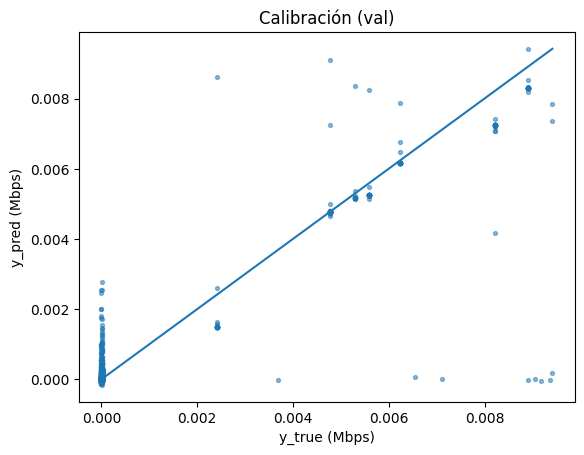

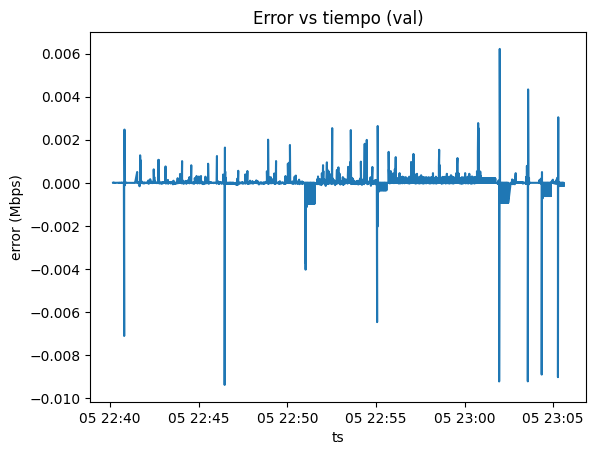

In [ ]:
import matplotlib.pyplot as plt

# y_true vs y_pred
plt.figure()
plt.scatter(va["y_true"]/1e6, va["y_pred"]/1e6, s=8, alpha=0.5)
lims = [0, max(va["y_true"].max(), va["y_pred"].max())/1e6]
plt.plot(lims, lims)
plt.xlabel("y_true (Mbps)"); plt.ylabel("y_pred (Mbps)")
plt.title("Calibración (val)")
plt.show()

# residuo en el tiempo
plt.figure()
plt.plot(va["ts"], (va["y_pred"]-va["y_true"])/1e6)
plt.xlabel("ts"); plt.ylabel("error (Mbps)")
plt.title("Error vs tiempo (val)")
plt.show()


Training en tiempo real

In [ ]:
import time
from collections import deque, defaultdict
from joblib import load

HOST = os.getenv("DB_HOST")
PORT = os.getenv("DB_PORT")
DB   = os.getenv("DB_NAME")
USER = os.getenv("DB_USER")
PASS = os.getenv("DB_PASSWORD")  

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASS}@{HOST}:{PORT}/{DB}")

MODEL_PATH = os.getenv("MODEL_PATH", "xgb_bps_h1s_v3.joblib")
model = load(MODEL_PATH)

WINDOW = 5  # ventana para lags/MA/STD/slope
state_thr = defaultdict(lambda: deque(maxlen=WINDOW))
state_pps = defaultdict(lambda: deque(maxlen=WINDOW))
last_seen_ts = None  # Para polling incremental

FEATURES = [
  "throughput_bps_t","pps_t",
  "thr_lag1","thr_lag2","thr_lag3","thr_lag5",
  "pps_lag1","pps_lag2","pps_lag3","pps_lag5",
  "thr_ma_5","thr_std_5","pps_ma_5","thr_slope5"
]

def flow_id(row):
    return f"{row['src_ip']}:{row['src_port']}>{row['dst_ip']}:{row['dst_port']}/{row['protocol']}"

def build_features(fid, thr_now, pps_now):
    # buffers ya contienen históricos previos
    thr_hist = state_thr[fid]
    pps_hist = state_pps[fid]

    # lags (1,2,3,5)
    def lag(buf, k):
        return buf[-k] if len(buf) >= k else np.nan

    thr_lags = [lag(thr_hist, k) for k in [1,2,3,5]]
    pps_lags = [lag(pps_hist, k) for k in [1,2,3,5]]

    # incluir el valor actual para MA/STD
    thr_vals = list(thr_hist) + [thr_now]
    pps_vals = list(pps_hist) + [pps_now]

    thr_ma_5  = float(np.mean(thr_vals[-WINDOW:]))
    thr_std_5 = float(np.std(thr_vals[-WINDOW:], ddof=1)) if len(thr_vals[-WINDOW:]) >= 2 else 0.0
    pps_ma_5  = float(np.mean(pps_vals[-WINDOW:]))

    thr_slope5 = np.nan
    if len(thr_hist) >= 5:
        thr_slope5 = (thr_now - thr_hist[-5]) / 5.0

    feats = [
        thr_now, pps_now,
        *thr_lags, *pps_lags,
        thr_ma_5, thr_std_5, pps_ma_5, thr_slope5
    ]
    return np.array(feats, dtype=float)

def have_enough_context(fid):
    return len(state_thr[fid]) >= 5 and len(state_pps[fid]) >= 5

def poll_new_rows(conn, last_ts):
    base_q = """
    SELECT ts, src_ip, dst_ip, src_port, dst_port, protocol,
           throughput_bps_t, packets
    FROM flow_metrics_logs
    WHERE ($1::timestamptz IS NULL OR ts > $1)
    ORDER BY ts
    LIMIT 2000;
    """
    return pd.read_sql(base_q, conn, params=[last_ts])

def upsert_preds(conn, batch_df):
    if batch_df.empty:
        return
    # Inserta en bloque
    with conn.begin() as tr:
        batch_df.to_sql("pred_bps_h1s", con=conn, if_exists="append", index=False, method="multi")

# Loop principal de inferencia en tiempo real
with engine.connect() as conn:
    print("🟢 Iniciando inferencia en tiempo real (1s)...")
    while True:
        batch = poll_new_rows(conn, last_seen_ts)
        if not batch.empty:
            preds_out = []
            for _, row in batch.iterrows():
                fid = flow_id(row)
                thr_now = float(row["throughput_bps_t"])
                pps_now = float(row["pps_t"])

                # construir features y predecir SOLO si ya hay contexto suficiente
                if have_enough_context(fid):
                    feats = build_features(fid, thr_now, pps_now)
                    if np.isnan(feats).any():
                        # evitar NaNs residuales por si faltó algo raro
                        pass
                    else:
                        yhat = float(model.predict(feats.reshape(1,-1))[0])
                        preds_out.append({
                            "ts": row["ts"],
                            "src_ip": row["src_ip"], "dst_ip": row["dst_ip"],
                            "src_port": int(row["src_port"]), "dst_port": int(row["dst_port"]),
                            "protocol": int(row["protocol"]),
                            "throughput_bps_t": thr_now, "pps_t": pps_now,
                            "yhat_bps_next_1s": yhat,
                        })

                # actualizar estado (después de usar el valor actual)
                state_thr[fid].append(thr_now)
                state_pps[fid].append(pps_now)

            # guarda predicciones
            if preds_out:
                upsert_preds(conn, pd.DataFrame(preds_out))
                # log rápido
                last = preds_out[-1]
                print(f"→ Pred @ {last['ts']} {fid}: {last['yhat_bps_next_1s']/1e6:.2f} Mbps")

            # avanza marca de agua
            last_seen_ts = max(batch["ts"])

        # duerme medio segundo para latencias bajas de ingestión
        time.sleep(0.5)
